###**深度學習期中作業**
####AOI自動光學檢查
409336020 雷亭儀

**使用Wide Resnet101_32x8d得到最佳預測結果**

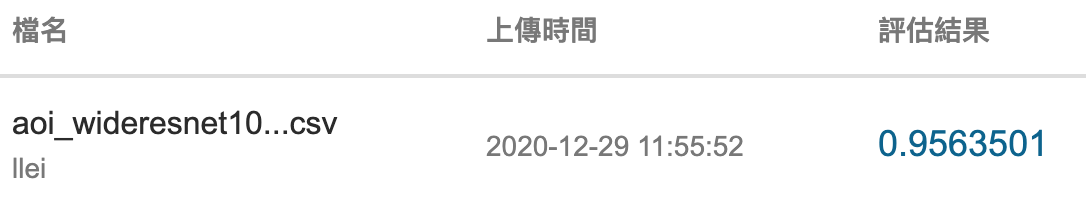

In [3]:
from IPython.display import Image
PATH = "/Users/apple/Documents/碩班深度學習/"
Image(filename = PATH + "result.png")

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from glob import glob

%matplotlib inline

In [48]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [49]:
os.getcwd()

'/content'

載入訓練資料

In [50]:
trainCSV=pd.read_csv("/content/drive/My Drive/DriveUploader/train.csv")

all_training_files = glob("/content/drive/My Drive/DriveUploader/*.png")
print(len(all_training_files))

#cloud_path = '/content'
#zip_path = '/content/aoi.zip'
to_path = '/content/drive/My Drive/DriveUploader'

2528


In [51]:
trainCSV.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


客製化AOI資料集

In [52]:
class aoiDataset(Dataset):
    def __init__(self, root, X, y, transform):
        ##############################################
        ### Initialize paths, transforms, and so on
        ### data list -> DataFrame ID, Label
        ##############################################
        self.transform = transform
        # 
        # load image path and annotations
        self.imgs = X
        self.imgs = [ '{}/{}'.format(root, img) for img in self.imgs ]
        self.lbls = y
        assert len(self.imgs) == len(self.lbls), 'mismatched length!'
        print ('Total data split: {}'.format(len(self.imgs)))
        
    def __getitem__(self, index):
        ##############################################
        # 1. Read from file (using numpy.fromfile, PIL.Image.open)
        # 2. Preprocess the data (torchvision.Transform).
        # 3. Return the data (e.g. image and label)
        ##############################################
        imgpath = self.imgs[index]
        img = Image.open(imgpath).convert('RGB')
        lbl = int(self.lbls[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, lbl
        
    def __len__(self):
        ##############################################
        ### Indicate the total size of the dataset
        ##############################################
        return len(self.imgs)

訓練模型的主程式

In [66]:
# 訓練模型
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {
        'loss_val': [],
        'loss_train': [],
        'acc_val': [],
        'acc_train': [],
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                history['acc_val'].append(epoch_acc)
                history['loss_val'].append(epoch_loss)
            else:
                history['acc_train'].append(epoch_acc)
                history['loss_train'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [67]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

新增resnet152、Wide Resnet101_32x8d、Wide Resnet101_2

In [68]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet152":
        """ Resnet152
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "wideresnet10132":
        """ Wide Resnet101_32x8d
        """
        model_ft = models.resnext101_32x8d(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "wideresnet101":
        """ Wide Resnet101_2
        """
        model_ft = models.wide_resnet101_2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

########
    elif model_name == "efficient":
        """ efficientnet
        """
        model_ft = EfficientNet.from_pretrained('efficientnet-b5')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft._fc.in_features
        model._fc = nn.Linear(num_ftrs,num_classes)
        input_size = 380
#########

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

for VGG model

In [56]:
# class VGG(nn.Module):
#     def __init__(self, dataset=None, pretrained=True, cfg=None, batch_norm=True):
#         super(VGG, self).__init__()
#         # Set number of model output and feature channel according to your dataset
#         if dataset == 'aoiDataset':
#             self.in_channels = 3
#             num_classes = 6
#             feature_channels = 512*7*7
        

#         # Define model structure according to cfg or using pretrained model
#         if pretrained:
#             print('Use pretrained VGG feature extractor')
#             if batch_norm:
#                 self.feature = torchvision.models.vgg16_bn(pretrained=True).features
#                 self.feature = nn.Sequential(*list(self.feature.children())[:-1])  # Remove pool5
#             else:
#                 self.feature = torchvision.models.vgg16(pretrained=True).features
#                 self.feature = nn.Sequential(*list(self.feature.children())[:-1])  # Remove pool5

#             self.classifier = nn.Linear(feature_channels, num_classes)
#         else:
#             if cfg is None:
#                 cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512]
#             self.feature = self.make_layers(cfg, batch_norm=batch_norm)
#             self.classifier = nn.Linear(feature_channels, num_classes)
#             self._initialize_weights()

#     def make_layers(self, cfg, batch_norm):
#         layers = []
#         for v in cfg:
#             if v == 'M':
#                 layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#             else:
#                 conv2d = nn.Conv2d(self.in_channels, v, kernel_size=3, padding=1, bias=True)
#                 if batch_norm:
#                     layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
#                 else:
#                     layers += [conv2d, nn.ReLU(inplace=True)]
#                 self.in_channels = v
                
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.feature(x)
#         x = nn.AvgPool2d(2)(x)
#         x = x.view(x.size(0), -1)
#         y = self.classifier(x)
        
#         return y

#     def _initialize_weights(self):
#         print('Initial model parameters...')
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#                 if m.bias is not None:
#                     m.bias.data.zero_()
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(0.5)
#                 m.bias.data.zero_()
#             elif isinstance(m, nn.Linear):
#                 m.weight.data.normal_(0, 0.01)
#                 m.bias.data.zero_() 

model setting

In [83]:
# Top level data directory. Here we assume the format of the directory conforms
# Models to choose from [resnet50, resnet152, alexnet, vgg, squeezenet, densenet, inception]
model_name = "wideresnet10132"

# Number of classes in the dataset
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [84]:
model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [85]:
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),  
                ]),
    'val': transforms.Compose([
                    transforms.Resize((input_size, input_size)),
                    transforms.CenterCrop(input_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225]),
                    ])
}

In [86]:
from sklearn.model_selection import train_test_split

X = np.array(trainCSV['ID'])
y = np.array(trainCSV['Label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=100)

In [87]:
# create train/val datasets
root = '{}'.format(to_path)

trainset = aoiDataset(root=root, 
                      X=X_train, y=y_train,
                      transform=data_transforms['train'])
valset = aoiDataset(root=root, 
                      X=X_test, y=y_test,
                      transform=data_transforms['val'])

# create train/val loaders
train_loader = DataLoader(dataset=trainset,
                          batch_size=16, 
                          shuffle=True,
                          num_workers=4)
                        # pin_memory=True)

val_loader = DataLoader(dataset=valset,
                        batch_size=16, 
                        shuffle=False,
                        num_workers=4)
                      # pin_memory=True)

Total data split: 2224
Total data split: 304


優化器

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

Params to learn:
	 fc.weight
	 fc.bias


In [99]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=False)

Epoch 0/19
----------
train Loss: 0.3259 Acc: 0.8934
val Loss: 0.1527 Acc: 0.9474

Epoch 1/19
----------
train Loss: 0.2990 Acc: 0.8970
val Loss: 0.1421 Acc: 0.9539

Epoch 2/19
----------
train Loss: 0.3163 Acc: 0.8903
val Loss: 0.1593 Acc: 0.9605

Epoch 3/19
----------
train Loss: 0.3137 Acc: 0.8912
val Loss: 0.1538 Acc: 0.9507

Epoch 4/19
----------
train Loss: 0.2894 Acc: 0.8970
val Loss: 0.1517 Acc: 0.9572

Epoch 5/19
----------
train Loss: 0.3169 Acc: 0.8948
val Loss: 0.1564 Acc: 0.9507

Epoch 6/19
----------
train Loss: 0.2940 Acc: 0.9015
val Loss: 0.1420 Acc: 0.9474

Epoch 7/19
----------
train Loss: 0.2900 Acc: 0.9096
val Loss: 0.1561 Acc: 0.9441

Epoch 8/19
----------
train Loss: 0.2932 Acc: 0.9042
val Loss: 0.1462 Acc: 0.9441

Epoch 9/19
----------
train Loss: 0.3037 Acc: 0.8966
val Loss: 0.1556 Acc: 0.9441

Epoch 10/19
----------
train Loss: 0.3142 Acc: 0.8867
val Loss: 0.1475 Acc: 0.9507

Epoch 11/19
----------
train Loss: 0.3132 Acc: 0.8916
val Loss: 0.1609 Acc: 0.9507

Ep

In [101]:
output_path = '{}/{}'.format(to_path, 'aoi_{}_20203.pth'.format(model_name))
# torch.save colab 會有 error output, 不需要理會
torch.save(model, output_path)

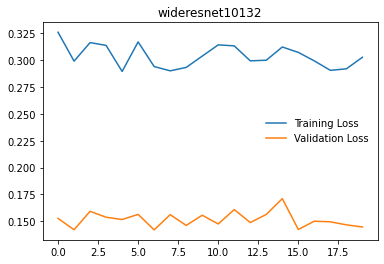

In [102]:
plt.title(model_name)
plt.plot(history['loss_train'], label='Training Loss')
plt.plot(history['loss_val'], label='Validation Loss')
# plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [103]:
df_test = pd.read_csv("/content/drive/My Drive/DriveUploader/test.csv")
df_test['Label'] = 0

df_test.head()

,ID,Label
0,test_00000.png,0
1,test_00001.png,0
2,test_00002.png,0
3,test_00003.png,0
4,test_00004.png,0


In [104]:
# load model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
output_path = '{}'.format(output_path)
model = torch.load(output_path)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [105]:
# create train/val datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

test_root = '{}/{}'.format(to_path, 'test_images')


testset = aoiDataset(root=test_root, 
                      X=np.array(df_test['ID']), y=np.array(df_test['Label']),
                      transform=data_transforms['val'])

testloader = DataLoader(dataset=testset,
                        batch_size=16, 
                        shuffle=False,
                        num_workers=4)

Total data split: 10142


In [106]:
all_testing_files = glob("/content/drive/My Drive/DriveUploader/test_images/*.png")
print(len(all_testing_files))

10142


驗證testing set

In [107]:
test_output = []

for inputs, labels in testloader:
    outputs = model(inputs.to(device)) 
    _, predicted = torch.max(outputs, 1)
    test_output += predicted.tolist()

In [109]:
df_output = df_test.copy()
df_output['Label'] = test_output
df_output.head(10)

,ID,Label
0,test_00000.png,1
1,test_00001.png,2
2,test_00002.png,5
3,test_00003.png,0
4,test_00004.png,2
5,test_00005.png,5
6,test_00006.png,5
7,test_00007.png,5
8,test_00008.png,0
9,test_00009.png,2


In [110]:
df_output.to_csv( '{}/{}'.format(to_path, 'aoi_{}.csv'.format(model_name)), index=0)